In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from pysim import SIMBoostRegressor, SIMAdaBoostClassifier, SIMLogitBoostClassifier

**Hyperparameters**

- n_estimators: the maximum number of sim estimators. default=5

- val_ratio: the ratio of validation set for tuning hyperparameters of each sim estimator and early stopping. default=0.2

- early_stop_thres: early stop threshold, the boosting will stop if the validation accuracy does not improve for early_stop_thres times. default=1

- random_state: the random seed. default=0

## Regression

```python
from pysim import SIMBoostRegressor
clf = SIMBoostRegressor(n_estimators=5, val_ratio=0.2, early_stop_thres=1, random_state=0)
## clf.fit(x, y)
```

In [2]:
def data_generator1_reg(random_state=0):
    
    np.random.seed(random_state)
    # data generation
    beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
    beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
    beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])
    
    beta = np.vstack([beta1,beta2,beta3])
    model_list = [lambda x: 0.2*np.exp(-4*x), lambda x: 3*x**2, lambda x: 2.5*np.sin(1.5 * np.pi*x)]
    
    x = truncnorm.rvs(a=-3,b=3,loc = 0, scale=1/3, size=(20000,10),random_state=random_state)
    noise = np.random.randn(20000).reshape(-1, 1)
    y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
                   3 * (np.dot(x, beta2))**2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + noise
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return beta, model_list, train_x, test_x, train_y, test_y

In [3]:
beta, model_list, train_x, test_x, train_y, test_y = data_generator1_reg()

clf = SIMBoostRegressor(n_estimators=5)
clf.fit(train_x, train_y)
mean_squared_error(test_y, clf.predict(test_x))

1.023658664723158

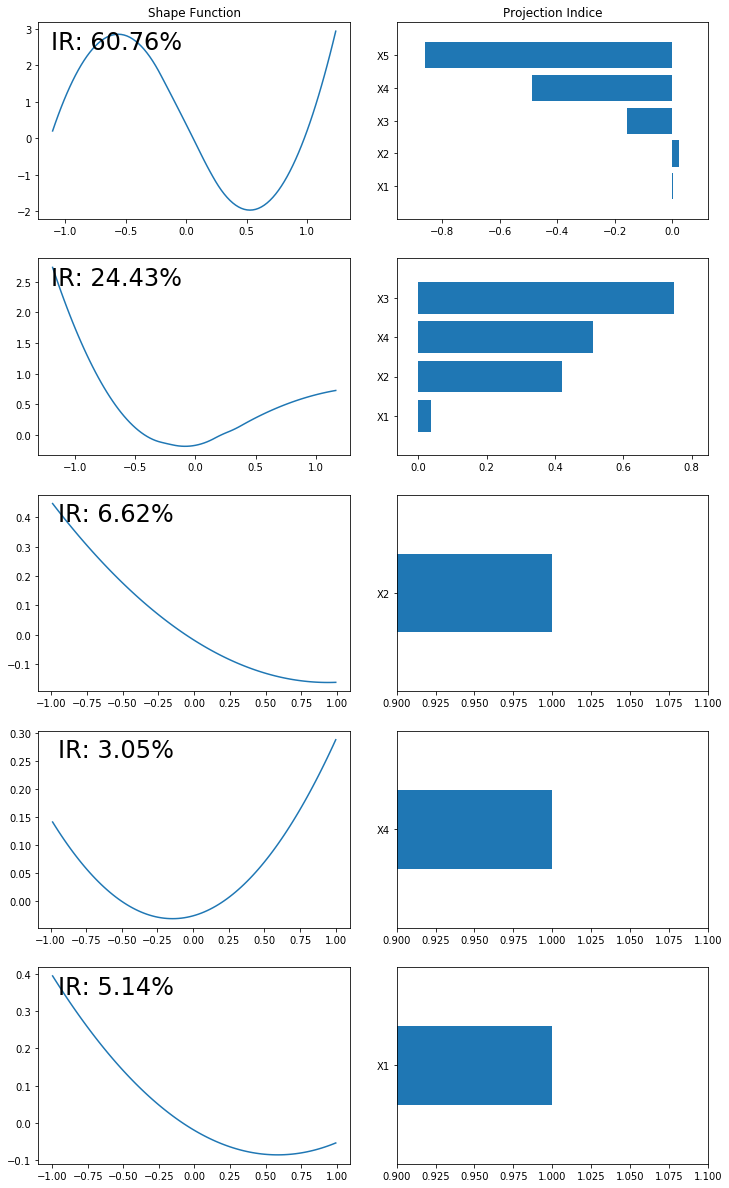

In [4]:
clf.visualize()

## Classification

```python
from pysim import SIMLogitBoostClassifier
clf = SIMLogitBoostClassifier(n_estimators=5, val_ratio=0.2, early_stop_thres=1, random_state=0)
## clf.fit(x, y)
```

In [5]:
def data_generator1_cls(random_state=0):
    
    np.random.seed(random_state)
    # data generation
    beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
    beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
    beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])
    
    beta = np.vstack([beta1,beta2,beta3])
    model_list = [lambda x: 0.2*np.exp(-4*x), lambda x: 3*x**2, lambda x: 2.5*np.sin(1.5 * np.pi*x)]
    
    x = truncnorm.rvs(a=-3,b=3,loc = 0, scale=1/3, size=(20000,10),random_state=random_state)
    noise = np.random.randn(20000).reshape(-1, 1)
    y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
                   3 * (np.dot(x, beta2))**2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + noise
    y = np.sign(y)
    y = (y + 1) / 2 
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return beta, model_list, train_x, test_x, train_y, test_y

In [6]:
beta, model_list, train_x, test_x, train_y, test_y = data_generator1_cls()

clf = SIMLogitBoostClassifier(n_estimators=5, early_stop_thres=1)
clf.fit(train_x, train_y)
roc_auc_score(test_y, clf.predict_proba(test_x))

0.929582694790845

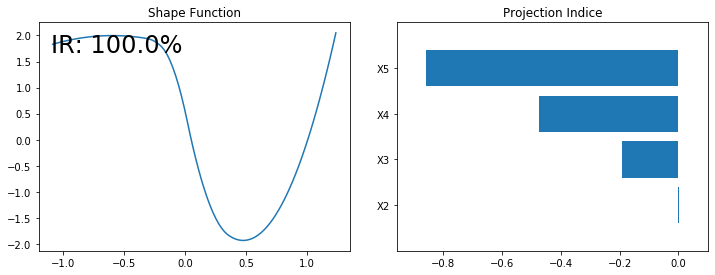

In [7]:
clf.visualize()

In [8]:
beta, model_list, train_x, test_x, train_y, test_y = data_generator1_cls()

clf = SIMAdaBoostClassifier(n_estimators=5, early_stop_thres=1)
clf.fit(train_x, train_y)
roc_auc_score(test_y, clf.predict_proba(test_x))

ValueError: operands could not be broadcast together with shapes (16000,) (16000,2) (16000,) 

In [23]:
from pysim import SIMRegressor, SIMClassifier
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score

x = train_x
y = train_y
n_samples, n_features = x.shape
indices = np.arange(n_samples)
idx1, idx2 = train_test_split(indices, test_size=clf.val_ratio, random_state=clf.random_state)
val_fold = np.ones((len(indices)))
val_fold[idx1] = -1
sample_weight = np.ones(n_samples) / n_samples
roc_auc_opt = -np.inf
clf.estimators_ = []
for i in range(clf.n_estimators):

    # fit SIM estimator
    param_grid = {"method": ["second_order", 'first_order']}
    grid = GridSearchCV(SIMClassifier(degree=2, knot_num=20, spline="a_spline", reg_lambda=0.1, reg_gamma=10,
                           random_state=clf.random_state), 
                  scoring={"auc": make_scorer(roc_auc_score)}, refit=False,
                  cv=PredefinedSplit(val_fold), param_grid=param_grid, verbose=0, error_score=np.nan)
    # time
    grid.fit(x, y, sample_weight=sample_weight)
    estimator = grid.estimator.set_params(**grid.cv_results_['params'][np.where((grid.cv_results_['rank_test_auc'] == 1))[0][0]])
    estimator.fit(x[idx1, :], y[idx1], sample_weight=sample_weight[idx1])

    y_codes = np.array([-1., 1.])
    y_coding = y_codes.take([0, 1] == y)
    with np.errstate(divide='ignore', over='ignore'):
        sample_weight *= np.exp(-0.5 * np.sum(y_coding * np.log(np.hstack([1 - estimator.predict_proba(x),
                                                     estimator.predict_proba(x)])), axis=1))

    pred_proba = estimators_.predict_proba(x[idx2, :])
    pred_proba = np.clip(pred_proba, np.finfo(pred_proba.dtype).eps, None)
    log_proba = np.log(pred_proba)
    pred_val = clf.decision_function(x[idx2, :]) + (log_proba - (1. / 2) * log_proba.sum(axis=1)[:, np.newaxis])
    pred_val_proba = 1 / (1 + np.exp(- pred_val))
    roc_auc_new = roc_auc_score(y[idx2], pred_val_proba)
    # stop criterion
    if roc_auc_opt < roc_auc_new:           
        roc_auc_opt = roc_auc_new
        early_stop_count = 0
    else:
        early_stop_count +=1

    if early_stop_count >= clf.early_stop_thres:
        break

    # update
    clf.estimators_.append(estimator)


NameError: name 'estimators_' is not defined

In [22]:
np.exp(-0.5 * np.sum(y_coding * np.log(np.hstack([1 - estimator.predict_proba(x),
                                                  estimator.predict_proba(x)])), axis=1))

array([0.49863973, 1.95108236, 0.08658296, ..., 0.28177373, 1.04054084,
       0.27838593])

In [20]:
y_codes = np.array([-1., 1.])
y_coding = y_codes.take([0, 1] == y)
y_coding

array([[ 1., -1.],
       [-1.,  1.],
       [-1.,  1.],
       ...,
       [ 1., -1.],
       [ 1., -1.],
       [ 1., -1.]])

In [21]:
np.sum(y_coding * np.log(np.hstack([1 - estimator.predict_proba(x), estimator.predict_proba(x)])), axis=1)

array([ 1.39174285, -1.33676855,  4.89330453, ...,  2.5333018 ,
       -0.07948124,  2.55749379])

In [ ]:
clf.visualize()

In [ ]:
# import scipy
# import numpy as np
# import pandas as pd 
# from scipy.linalg import cholesky
# from matplotlib import pyplot as plt

# from sklearn.datasets import make_classification
# from patsy import dmatrix, build_design_matrices

# from pysim import SIMClassifier
# from pysim.aspline import ASplineClassifier

# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)

# x = X[:, [1]]
# clf = ASplineClassifier(xmin=x.min(), xmax=x.max(), knot_num=10)
# n_samples, n_features = x.shape
# sample_weight = np.ones(n_samples) / n_samples
# def diff_matrix(order, knot_num):
#     results = [] # a container to collect the rows
#     n_rows = order + 2
#     for _ in range(n_rows): 
#         row = [1] # a starter 1 in the row
#         if results: # then we're in the second row or beyond
#             last_row = results[-1] # reference the previous row
#             row.extend([sum(pair) for pair in zip(last_row, last_row[1:])])
#             row.append(1)
#         results.append(row) # add the row to the results.

#     diss_operator = [] # a container to collect the rows
#     for i, item in enumerate(np.array(row)):
#         diss_operator.append(item * (-1) ** i)
#     diss_operator.reverse()
#     D = np.zeros((knot_num, knot_num + order + 1), dtype=np.float32)
#     for i in range(knot_num):
#         D[i,i:(i+order+2)] = diss_operator
#     return D

# def link(x):
#     with np.errstate(divide='ignore', over='ignore'):
#         return 1 / (1 + np.exp(-x))

# def inv_link(x):
#     with np.errstate(divide='ignore', over='ignore'):
#         return np.log(x) - np.log(1 - x)

# def get_loss(label, pred):
#     with np.errstate(divide='ignore', over='ignore'):
#         pred = np.clip(pred, 10**(-8), 1. -  10**(-8))
#         return - np.mean(label * np.log(pred) + (1 - label) * np.log(1 - pred))

# x = xb
# y = y
# sample_weight = np.ones(n_samples)

# knots = list(np.linspace(x.min(), x.max(), clf.knot_num + 2, dtype=np.float32)[1:-1])
# xphi = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1",
#                {"x": [x.min(), x.max()], "knots": knots, "degree": clf.degree})
# init_basis = np.asarray(build_design_matrices([xphi.design_info],
#                   {"x": x, "knots": knots, "degree": clf.degree})[0])

# tempy = 1.0 * y.copy()
# tempy[tempy==0] = 0.01
# tempy[tempy==1] = 0.99
# D = diff_matrix(clf.degree, clf.knot_num)
# update_w = np.ones([clf.knot_num, 1], dtype=np.float32) 
# DWD = np.tensordot(D * update_w.reshape([-1, 1]), D, axes=([0], [0]))
# BWB = np.tensordot(init_basis * sample_weight.reshape([-1, 1]), init_basis, axes=([0], [0]))
# BWY = np.tensordot(init_basis * sample_weight.reshape([-1, 1]), inv_link(tempy), axes=([0], [0]))
# update_a = np.dot(np.linalg.pinv(BWB + clf.reg_gamma * DWD), BWY)
# best_loss = get_loss(y, link(np.dot(init_basis, update_a)))
# for i in range(100):
#     best_loss_irls = np.inf
#     for j in range(10):
#         lp = np.dot(init_basis, update_a)
#         mu = link(lp)
#         omega = mu * (1 - mu)
#         mask = (np.abs(omega) >= 10**(-8)) * np.isfinite(omega)
#         mask = mask.ravel()
#         if np.sum(mask) == 0:
#             break

#         BW = init_basis[mask, :] * sample_weight[mask].reshape([-1, 1])
#         DWD = np.tensordot(D * update_w.reshape([-1, 1]), D, axes=([0], [0]))
#         BWOB = np.tensordot(BW * omega[mask].reshape([-1, 1]), init_basis[mask, :], axes=([0], [0]))
#         update_a_temp = np.dot(np.linalg.pinv(BWOB + clf.reg_gamma * DWD),
#                         BWOB.dot(update_a) + np.tensordot(BW, y[mask] - mu[mask], axes=([0], [0])))
#         new_loss = get_loss(y, link(np.dot(init_basis, update_a_temp)))
#         print(new_loss)
#         if new_loss - best_loss_irls >= 0:
#             break
#         best_loss_irls = new_loss
#         update_a = update_a_temp

#     print("Outer", best_loss_irls, best_loss)
#     if best_loss_irls - best_loss >= 0:
#         break
#     best_loss = best_loss_irls
#     update_w = 1 / (np.dot(D, update_a) ** 2 + 0.00001 ** 2)